<a href="https://colab.research.google.com/github/sfuller14/handson-ml2/blob/master/Copy_of_Module_3_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MODULE 3**
(Build on last week's work.)

In [1]:
# Import necessary packages/modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import io
from google.colab import files

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso, LassoCV, RidgeCV, Ridge, ElasticNetCV, ElasticNet
from sklearn.model_selection import GridSearchCV

import statsmodels.api as sm
from scipy import stats

from numpy import std
from numpy import mean
from numpy import absolute
from numpy import sqrt

!pip install mlinsights
from mlinsights.mlmodel import PiecewiseRegressor

!pip install pingouin
import pingouin as pg

# set up notebook to display multiple output from cells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Upload House Prices training file
uploaded = files.upload()
 
data = pd.read_csv(io.BytesIO(uploaded['train.csv']))

Saving test.csv to test.csv
Saving train.csv to train.csv


Our data consists of 81 columns and 1460 observations. 

Our target column is SalePrice. 

The feature columns consist of integer, continuous and string values. For linear regression we will want to transform features in string format into a numeric representation as well as normalize numeric values for consistent weighting.

## EDA requirement

In [3]:
# descriptive stats of Sale Price
data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Text(0.5, 1.0, 'House Sale Price Distribution')

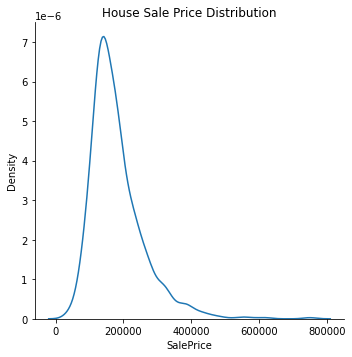

In [4]:
# distribution plot of sale price
sns.displot(data, x="SalePrice",kind="kde")
plt.title('House Sale Price Distribution')
plt.show()

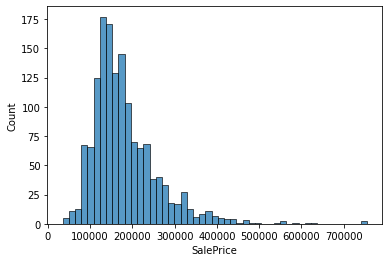

In [5]:
# similar distribution plot as histogram presenting counts
sns.histplot(x = 'SalePrice', data = data)

There are 1460 instances in the training set, and the average home price is $180,921. The distribution is skewed right, as the median home price is less than that of the mean.

In [6]:
# count occurence of missing data
null_values = data.isnull().sum()
# display sum of columns with missing data over zero
null_values[null_values > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

<Figure size 1440x360 with 0 Axes>

Text(0.5, 1.0, 'Column Missing Value Heatmap')

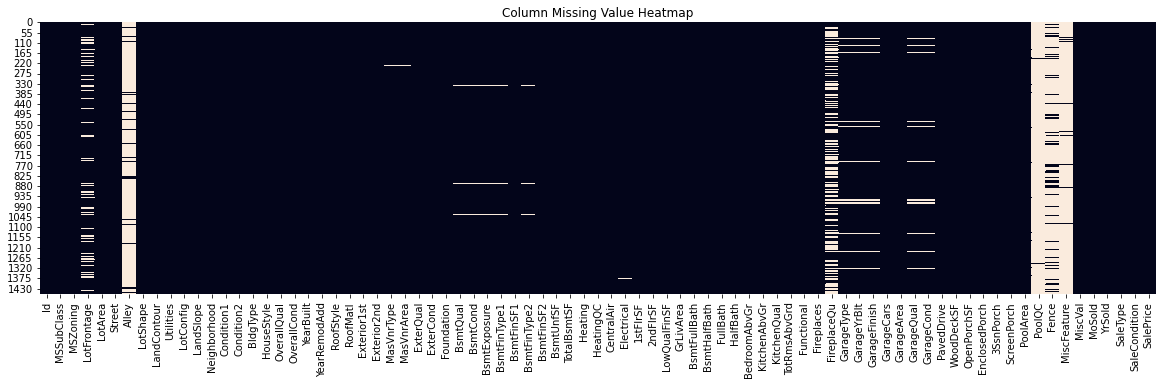

In [7]:
# heatmap of missing data 
plt.figure(figsize = (20,5))
sns.heatmap(data.isnull(), cbar = False)
plt.title('Column Missing Value Heatmap')
plt.show()

<a name=#catmissing></a>
Null values for this dataset might be categorized in two ways - those that indicate a house is missing a feature, and features that are missing due to dirty data. Looking at the missing values from the columns above we see a pattern - none of the missing values fall into categories that necessitate a house, such as the existence of a bedroom or kitchen. Further, when we look at groups of features we see that if there is a missing value the value is missing consistently for the row. This indicates that the former of the two cases is true for this dataset, and that null values are due to a feature missing from a house. The absense of a feature may contribute to a regression prediction and it may be worthwhile to transform these values into a zero value or null equivalent.

There are a few features with many missing values, such as Alley, PoolQC, Fence, and MiscFeature. We could possibly drop these features given the many missing values.

In [8]:
# Dropping categorical variables to 1) avoid too many features and 
# 2) to drop features with missing many values
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
data_numerics_only = data.select_dtypes(include=numerics)

In [9]:
# Rechecking nan values
data_numerics_missing = data_numerics_only.isna().sum()
data_numerics_missing[data_numerics_missing > 0]

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

<a name="numnull"></a>
After re-checking nan values in the numerical values, there are still 3 columns we will either need to impute or drop.


*   GarageYrBlt - will impute YearBuilt values into missing values in this column (assumes that garages were built the same year as the houses for imputed data points) 
*   LotFrontage - drop the feature, as about 18% of the data points are missing this information
*   MasVnrArea - impute using mean, given there are only 8 data points







In [10]:
# fill GarageYrBlt missing values with corresponding YearBuilt values
data_numerics_only['GarageYrBlt'].fillna(data_numerics_only['YearBuilt'], inplace=True)

# drop LotFrontage feature
data_numerics_only.drop(['LotFrontage'], axis=1, inplace=True)

# impute MasVnrArea missing values with mean value
data_numerics_only['MasVnrArea'].fillna(data_numerics_only['MasVnrArea'].mean(), inplace=True)

# view new DataFrame info to ensure no missing values
data = data_numerics_only.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   LotArea        1460 non-null   int64  
 3   OverallQual    1460 non-null   int64  
 4   OverallCond    1460 non-null   int64  
 5   YearBuilt      1460 non-null   int64  
 6   YearRemodAdd   1460 non-null   int64  
 7   MasVnrArea     1460 non-null   float64
 8   BsmtFinSF1     1460 non-null   int64  
 9   BsmtFinSF2     1460 non-null   int64  
 10  BsmtUnfSF      1460 non-null   int64  
 11  TotalBsmtSF    1460 non-null   int64  
 12  1stFlrSF       1460 non-null   int64  
 13  2ndFlrSF       1460 non-null   int64  
 14  LowQualFinSF   1460 non-null   int64  
 15  GrLivArea      1460 non-null   int64  
 16  BsmtFullBath   1460 non-null   int64  
 17  BsmtHalfBath   1460 non-null   int64  
 18  FullBath

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Text(0.5, 1.0, 'House Sale Price Boxplot Distribution')

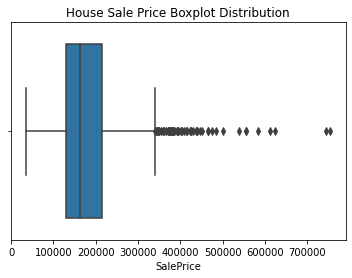

In [11]:
# boxplot distribution of House Sale Price to investigate outliers
sns.boxplot(x=data["SalePrice"])
plt.title('House Sale Price Boxplot Distribution')
plt.show()

Text(0.5, 1.0, 'House Sale Price Distribution: Outliers at 3x IQR')

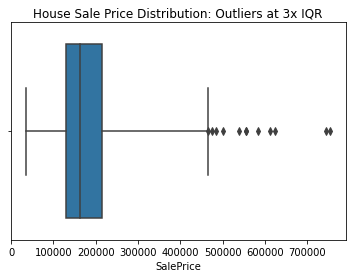

In [12]:
# boxplot with whiskers adjusted to show extreme outliers (3 * IQR)
sns.boxplot(data = data, x = 'SalePrice', whis = 3)
plt.title('House Sale Price Distribution: Outliers at 3x IQR')
plt.show()

All (extreme) outliers appear to be on the high end of SalePrice. Let's look at each of the extreme outliers individually with several of the other features.

In [13]:
# display extreme outliers of SalePrice with several other features
Q1, Q3 = data['SalePrice'].quantile([0.25, 0.75])
IQR = Q3 - Q1
outliers = data[(data['SalePrice'] < Q1 - 3 * IQR) | (data['SalePrice'] > Q3 + 3 * IQR)]
# removed external quality
outliers[['Id', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', 'GrLivArea', 'GarageCars', 'GarageArea',
          'YrSold', 'SalePrice']]

,Id,LotArea,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,GarageCars,GarageArea,YrSold,SalePrice
178,179,17423,9,2008,2009,2216,2234,3,1166,2009,501837
185,186,22950,10,1892,1993,1107,3608,3,840,2006,475000
440,441,15431,10,2008,2008,3094,2402,3,672,2009,555000
691,692,21535,10,1994,1995,2444,4316,3,832,2007,755000
769,770,53504,8,2003,2003,1650,3279,3,841,2010,538000
798,799,13518,9,2008,2009,1926,3140,3,820,2009,485000
803,804,13891,9,2008,2009,1734,2822,3,1020,2009,582933
898,899,12919,9,2009,2010,2330,2364,3,820,2010,611657
1046,1047,16056,9,2005,2006,1992,2868,3,716,2006,556581
1169,1170,35760,10,1995,1996,1930,3627,3,807,2006,625000


## Enhanced EDA Requirement

In [14]:
# To enhance our variable exploration portion, we want to find the partial correlation between YearBuilt and OverallQual while holding YearRemodAdd constant.

# First find correlation between YearBuilt and OverallQual as a baseline comparison.
corr_YearBuilt_and_OverallQual = data['YearBuilt'].corr(data['OverallQual'])

# Then find the correlation between YearBuilt and OverallQual while holding constant.
partial_correlation_Yearbuilt_and_OverallQual = pg.partial_corr(data=data, x='YearBuilt', y='OverallQual', covar='YearRemodAdd')

print('Correlation = ', corr_YearBuilt_and_OverallQual, 'Partial correlation = ', partial_correlation_Yearbuilt_and_OverallQual)

Correlation =  0.5723227689623612 Partial correlation =              n         r         CI95%         p-val
pearson  1460  0.365733  [0.32, 0.41]  2.109404e-47


To interpret the results, the two variables YearBuilt and OverallQual are somewhat correlated (0.5723), but less so when the variable YearRemodAdd is held constant (0.3657). These results are somewhat credible, as the p-value is sufficiently low. 
What does this really mean? YearRemodAdd seems to be a confounding variable when you're looking at YearBuilt and OverallQual. When you remove it, the correlation between YearBuilt and OverallQual is quite a bit lower.

## Feature Engineering Requirement

In [15]:
# sorted correlation of feature candidates relative to Sale Price
data.corr()['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
GarageYrBlt      0.508043
YearRemodAdd     0.507101
MasVnrArea       0.475241
Fireplaces       0.466929
BsmtFinSF1       0.386420
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

Text(0.5, 1.0, 'Feature Correlation Heatmap')

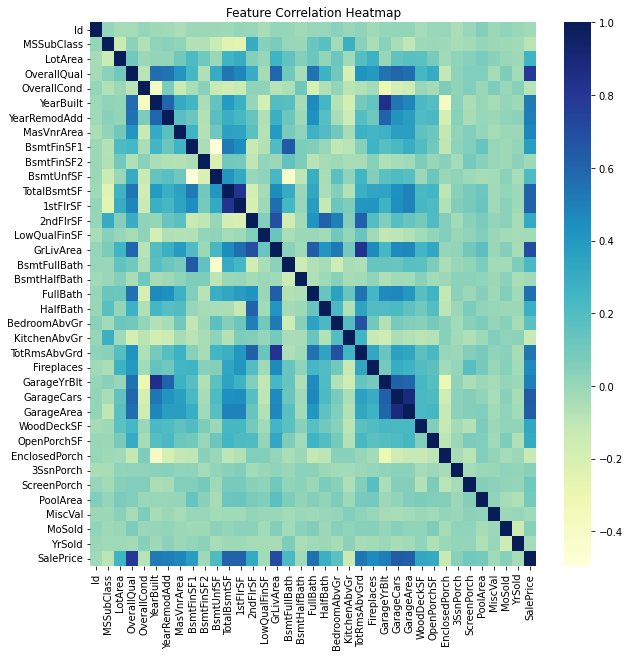

In [16]:
# create heatmap of correlations
fig, ax = plt.subplots(figsize=(10,10)) 

sns.heatmap(data.corr(), cmap="YlGnBu", ax=ax)
plt.title('Feature Correlation Heatmap')
plt.show()

Overall Quality Predictor

Text(0.5, 1.0, 'Sale Price Boxplots Split by Overall Quality')

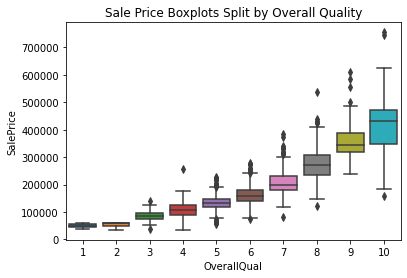

In [17]:
# boxplot of Sale Price split by overall quality
sns.boxplot(data=data, x="OverallQual", y="SalePrice")
plt.title('Sale Price Boxplots Split by Overall Quality')
plt.show()

Garage Area & Cars

Text(0.5, 1.0, 'Sale Price Distribution by Garage Size and Car Capacity')

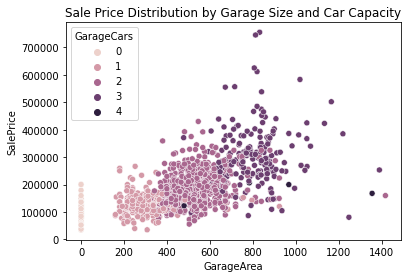

In [18]:
# scatter plot of Sale Price and Garage Area with number of cars as hue
sns.scatterplot(data=data, x="GarageArea", y="SalePrice", hue="GarageCars")
plt.title('Sale Price Distribution by Garage Size and Car Capacity')
plt.show()

GrLiv Area Predictor

Text(0.5, 1.0, 'Sale Price and Livable Space Above Ground')

Text(0.5, 0, 'Livable Space Above Ground: sqft')

Text(0, 0.5, 'Sale Price')

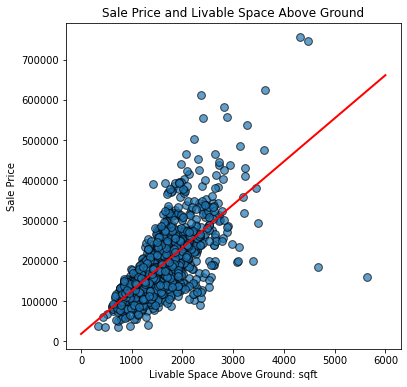

In [19]:
# set dimensional constraints for plot
fig, ax = plt.subplots(figsize = (6, 6))

# scatterplot of SalePrice by livable area above ground
ax.scatter(data['GrLivArea'], data['SalePrice'], s=60, alpha=0.7, edgecolors="k")

# fit a line of best fit to data
b, a = np.polyfit(data['GrLivArea'], data['SalePrice'], deg=1)
 
# sequential list for plotting
xseq = np.linspace(0, 6000, num=6000)

# Plot regression line
ax.plot(xseq, a + b * xseq, color="r", lw=2)

# labels
plt.title('Sale Price and Livable Space Above Ground')
plt.xlabel('Livable Space Above Ground: sqft')
plt.ylabel('Sale Price')
plt.show()

### feature set 1

Text(0.5, 1.0, 'YearBuilt Boxplot')

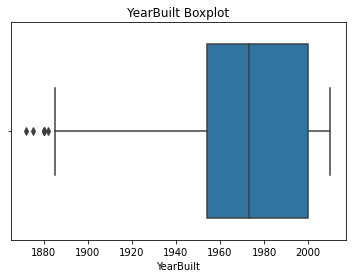

Text(0.5, 1.0, 'YearRemodAdd Boxplot')

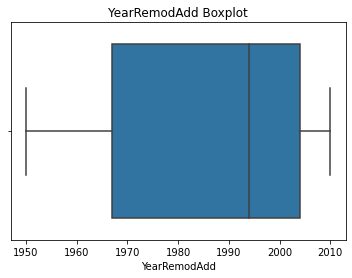

Text(0.5, 1.0, 'GarageYrBlt Boxplot')

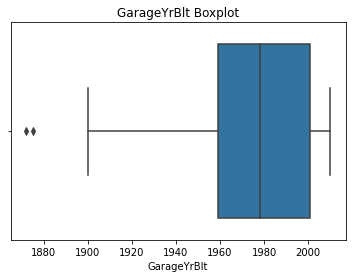

Text(0.5, 1.0, 'YrSold Boxplot')

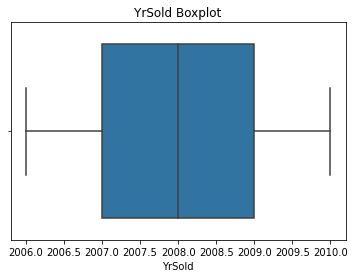

In [20]:
# list of columns with year values
year_features = ['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold']

# loop through each column in year list and generate boxplot
for col in year_features:
    sns.boxplot(x = data[col])
    plt.title("{} Boxplot".format(col))
    plt.show()

Text(0.5, 1.0, 'building_age Boxplot')

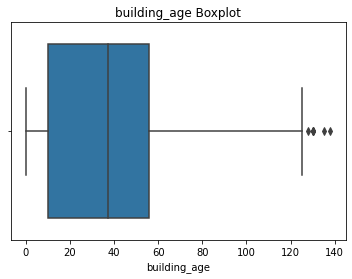

Text(0.5, 1.0, 'time_since_remod Boxplot')

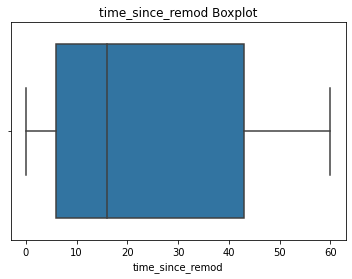

Text(0.5, 1.0, 'garage_age Boxplot')

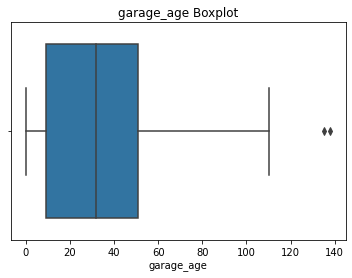

Text(0.5, 1.0, 'time_since_sale Boxplot')

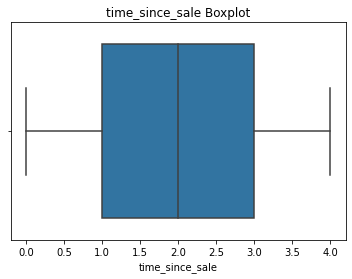

In [21]:
# list of names that will be used to name columns
year_new_features = ['building_age','time_since_remod','garage_age', 'time_since_sale']

# loop through both year lists, create a new column, subtract the most recent year (2010)
# from each column to get relative age
for year_feature, new_year_feature in zip(year_features, year_new_features):
  data[new_year_feature] =  data.loc[:, year_features].max().max() - data[year_feature]

# loop through and boxplot created features
for col in year_new_features:
    sns.boxplot(x = data[col])
    plt.title("{} Boxplot".format(col))
    plt.show()

### feature set 2

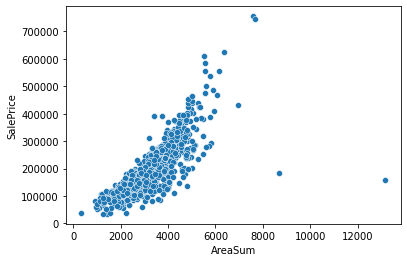

In [22]:
# try adding together GrLivArea, GarageArea, and TotalBsmtSF as a new feature
data['AreaSum'] = data['GrLivArea'] + data['GarageArea'] + data['TotalBsmtSF']

# create scatterplot to view this new AreaSum feature
sns.scatterplot(data = data, x = 'AreaSum', y = 'SalePrice')

In [23]:
# show correlations with new AreaSum feature
data.corr()['SalePrice'].sort_values(ascending = False)

SalePrice           1.000000
AreaSum             0.807518
OverallQual         0.790982
GrLivArea           0.708624
GarageCars          0.640409
GarageArea          0.623431
TotalBsmtSF         0.613581
1stFlrSF            0.605852
FullBath            0.560664
TotRmsAbvGrd        0.533723
YearBuilt           0.522897
GarageYrBlt         0.508043
YearRemodAdd        0.507101
MasVnrArea          0.475241
Fireplaces          0.466929
BsmtFinSF1          0.386420
WoodDeckSF          0.324413
2ndFlrSF            0.319334
OpenPorchSF         0.315856
HalfBath            0.284108
LotArea             0.263843
BsmtFullBath        0.227122
BsmtUnfSF           0.214479
BedroomAbvGr        0.168213
ScreenPorch         0.111447
PoolArea            0.092404
MoSold              0.046432
3SsnPorch           0.044584
time_since_sale     0.028923
BsmtFinSF2         -0.011378
BsmtHalfBath       -0.016844
MiscVal            -0.021190
Id                 -0.021917
LowQualFinSF       -0.025606
YrSold        

Creating this new AreaSum feature resulted in the highest correlation with SalePrice (approximately 0.81), providing a slight improvement over the OverallQual correlation with SalePrice (approximately 0.79). We can try to improve upon this further by combining these two features (AreaSum and OverallQual).

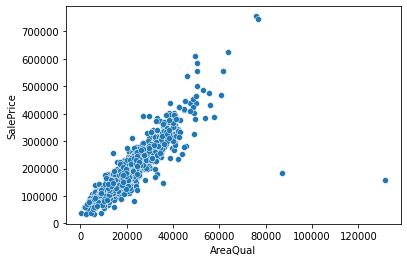

In [24]:
# try multiplying AreaSum and OverallQual features as a new feature
data['AreaQual'] = data['AreaSum'] * data['OverallQual']

# create scatterplot to view this new AreaQual feature
sns.scatterplot(data = data, x = 'AreaQual', y = 'SalePrice')

In [25]:
# show correlation of new AreaQual feature
data.corr()['SalePrice']['AreaQual']

0.8685876024971185

As seen in the correlation result, creating this new AreaQual feature improved the correlation with SalePrice even further to approximately 0.87. From the scatterplot, we can see that this correlation may have been even higher, if not for a couple potential outliers.

Outliers and influential values will prevent our model from generalizing. Let's remove those.

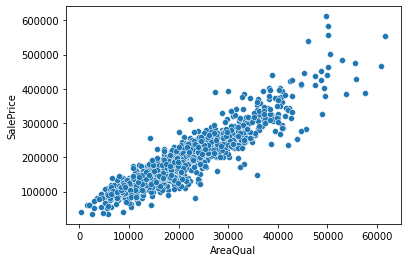

In [26]:
# limit data to those observations where AreaQual is less than 62000
data = data[data['AreaQual'] < 62000]
sns.scatterplot(data = data, x = 'AreaQual', y = 'SalePrice')

In [27]:
# check correlation of AreaQual and SalePrice with limited data
data.corr()['SalePrice']['AreaQual']

0.9192181381237393

Removing the outliers improved the correlation significantly. It is now almost 0.92.

## Initial/Baseline Model: Linear Regression

In [28]:
data = data.reset_index(drop=True)

In [29]:
# define the target and separate from features
target = data['SalePrice']
features = data.loc[:,data.columns != 'SalePrice']

# standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
features_df = pd.DataFrame(features_scaled, columns = features.columns)

# simplify
X = features_df
y = target

In [30]:
# 80:20 split
x_train = X.iloc[:round(len(X)*0.80)]
x_test = X.iloc[round(len(X)*0.80):]

y_train = y.iloc[:round(len(y)*0.80)]
y_test = y.iloc[round(len(y)*0.80):]

# build simple linear regression model
model = LinearRegression()

# x_t = x_train['AreaQual'].reshape(-1,1)
model.fit(x_train[['AreaQual']], y_train)

predictions = model.predict(x_test[['AreaQual']])

# calculate error
lin_mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print('RMSE:', sqrt(lin_mse))
print('R2:', r2)

LinearRegression()

RMSE: 28386.85143093815
R2: 0.8378170839701096


# Lasso Regression Requirement


In [31]:
# split the data into train test
x2_train = X.iloc[:round(len(X)*0.80)]
x2_test = X.iloc[round(len(X)*0.80):]

y_train = y.iloc[:round(len(y)*0.80)]
y_test = y.iloc[round(len(y)*0.80):]

In [32]:
# find optimal alpha
lasso_cv_model = LassoCV(alphas = list(range(1,500)), cv = 5).fit(x2_train, y_train)
lasso_cv_model.alpha_

149

In [33]:
# train lasso with optimal alpha
lasso_2 = Lasso().set_params(alpha = lasso_cv_model.alpha_).fit(x2_train, y_train)

# generate predictions
lasso_2_predictions = lasso_2.predict(x2_test)

# calculate error
lin_mse = mean_squared_error(y_test, lasso_2_predictions)
r2 = r2_score(y_test, lasso_2_predictions)

print('RMSE:', sqrt(lin_mse))
print('R2:', r2)

RMSE: 24419.630253842075
R2: 0.8799813263885188


In [34]:
def adjusted_r2(R2, training_set):
  return 1- ((1-R2)*(len(training_set)-1)/(len(training_set)-training_set.shape[1]-1))

In [35]:
adjusted_r2(r2, x2_train)

0.8754846410257335

In [36]:
pd.Series(lasso_2.coef_, index = x2_train.columns)

Id                    152.146796
MSSubClass          -3384.881659
LotArea              5691.374152
OverallQual        -21140.187908
OverallCond          6214.427991
YearBuilt            2827.985446
YearRemodAdd         1466.409398
MasVnrArea           1499.674509
BsmtFinSF1              0.000000
BsmtFinSF2          -2203.649339
BsmtUnfSF           -8089.157892
TotalBsmtSF         -3104.315776
1stFlrSF            -2258.041122
2ndFlrSF                0.000000
LowQualFinSF        -1013.298251
GrLivArea              -0.000000
BsmtFullBath         1504.099329
BsmtHalfBath         -521.720169
FullBath             1058.541289
HalfBath              982.489900
BedroomAbvGr        -5098.020616
KitchenAbvGr        -2658.690323
TotRmsAbvGrd         6951.367688
Fireplaces           2195.671446
GarageYrBlt             0.000000
GarageCars           1823.981935
GarageArea          -5743.939004
WoodDeckSF            510.481242
OpenPorchSF           291.793635
EnclosedPorch         973.455249
3SsnPorch 

### Test Set predictions - Lasso Regression

In [37]:
# Upload House Prices test file
uploaded = files.upload()
 
data = pd.read_csv(io.BytesIO(uploaded['test.csv']))

Saving test.csv to test (1).csv


In [38]:
# save data ids
ids = data['Id']

In [39]:
# Dropping categorical variables to 1) avoid too many features and 
# 2) to drop features with missing many values
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
data_numerics_only = data.select_dtypes(include=numerics)

In [40]:
# fill GarageYrBlt missing values with corresponding YearBuilt values
data_numerics_only['GarageYrBlt'].fillna(data_numerics_only['YearBuilt'], inplace=True)

# drop LotFrontage feature
data_numerics_only.drop(['LotFrontage'], axis=1, inplace=True)

# impute MasVnrArea missing values with mean value
data_numerics_only['MasVnrArea'].fillna(data_numerics_only['MasVnrArea'].mean(), inplace=True)

# view new DataFrame info to ensure no missing values
data = data_numerics_only.copy()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [41]:
# Adding new features to the test set
year_features = ['YearBuilt','YearRemodAdd']
year_new_features = ['building_age','time_since_remod']
for year_feature, new_year_feature in zip(year_features, year_new_features):
  data[new_year_feature] =  data.loc[:, year_features].max().max() - data[year_feature]

data['AreaSum'] = data['GrLivArea'] + data['GarageArea'] + data['TotalBsmtSF']
data['AreaQual'] = data['AreaSum'] * data['OverallQual']

In [42]:
# Filling in a few rows still having NaNs
data.fillna(0, inplace=True)

In [43]:
# normalize the data

features = data.loc[:,data.columns != 'SalePrice']
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
data = pd.DataFrame(features_scaled, columns = features.columns)

# limit the features to those included in X
X_test = pd.DataFrame()
for column in X.columns:
  if column in data.columns:
    X_test[column] = data[column]
  else:
    print(f'Note: The testing features do not include {column}.')

Note: The testing features do not include garage_age.
Note: The testing features do not include time_since_sale.


In [44]:
# identify differences in X and X_test
difference = list(set(X.columns.tolist())- set(X_test.columns.tolist()))
difference

['garage_age', 'time_since_sale']

In [45]:
# remove differences
X = X.drop(difference, axis = 1)

In [46]:
# Build model, fit it, and predict results here

In [47]:
lasso_cv_model = LassoCV(alphas = list(range(1,500)), cv = 5).fit(X, y)
lasso_cv_model.alpha_

74

In [48]:
# train lasso with optimal alpha
lasso_2 = Lasso().set_params(alpha = lasso_cv_model.alpha_).fit(X, y)

# generate predictions
results = lasso_2.predict(X_test)

In [49]:
results = pd.DataFrame({'Id': ids, 'SalePrice': results}).set_index('Id')
results.to_csv('Lasso_regression_results.csv')

## Ridge Regression Requirement

In [50]:
# Train/test split
# split the data into train test
x2_train = X.iloc[:round(len(X)*0.80)]
x2_test = X.iloc[round(len(X)*0.80):]

y_train = y.iloc[:round(len(y)*0.80)]
y_test = y.iloc[round(len(y)*0.80):]

In [51]:
# Find optimal alpha for Ridge Regression model (optimal alpha = 1)
regr_cv = RidgeCV(alphas = list(range(1,500)), cv = 5).fit(x2_train, y_train)
regr_cv.alpha_

1

In [52]:
# Define, fit, predict
model = Ridge(alpha=regr_cv.alpha_)
model.fit(x2_train, y_train)
Ridge_Regression_predictions = model.predict(x2_test)

Ridge(alpha=1)

In [53]:
# calculate R2 and RMSE
test_r2 = sklearn.metrics.r2_score(y_test, Ridge_Regression_predictions)
test_rmse = sklearn.metrics.mean_squared_error(y_test, Ridge_Regression_predictions)
print('R2 = ', test_r2, 'RMSE = ', test_rmse)

R2 =  0.8783682345753878 RMSE =  604333063.1616719


LASSO performed slightly better than Ridge Regression on the test data (training.csv data).

### Test set predictions - Ridge Regression

In [54]:
# Remove any columns missing from test data from x2_train, and refit model
x2_train = x2_train[list(data.columns)]
model.fit(x2_train, y_train)

# Predict fitted model on test set data (data already scaled and features were added from above)
Ridge_regression_test_predictions = model.predict(X_test)

Ridge(alpha=1)

## Elastic Net Requirement

In [55]:
# separate data into train and test data
X2_train, X2_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# build Elastic Net model with various l1_ratio and alpha values, and fit to data
l1_ratios = np.arange(0.1, 1.1, 0.1)
alphas = range(1, 101)
model = ElasticNetCV(l1_ratio = l1_ratios, alphas = alphas, cv = 5, max_iter = 100000)
model.fit(X, y)

# display optimal l1_ratio and alpha, as well as calculated coefficients
print(f'Optimal l1_ratio: {model.l1_ratio_}')
print(f'Optimal alpha: {model.alpha_}')
print(f'Calculated coefficients: \n{pd.Series(model.coef_, index = X2_train.columns)}')

# use model to predict train and test data
y_train_pred = model.predict(X2_train)
y_test_pred = model.predict(X2_test)

# calculate R2 for train and test data to compare
train_r2 = sklearn.metrics.r2_score(y_train, y_train_pred)
test_r2 = sklearn.metrics.r2_score(y_test, y_test_pred)

# calculate RMSE for train and test data to compare
train_rmse = sklearn.metrics.mean_squared_error(y_train, y_train_pred, squared = False)
test_rmse = sklearn.metrics.mean_squared_error(y_test, y_test_pred, squared = False)
                                                
# display results
print(f'Train R2: {train_r2}\nTrain RMSE: {train_rmse}\nTest R2: {test_r2}\nTest RMSE: {test_rmse}')

ElasticNetCV(alphas=range(1, 101), cv=5,
             l1_ratio=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
             max_iter=100000)

Optimal l1_ratio: 1.0
Optimal alpha: 74
Calculated coefficients: 
Id                    -79.390440
MSSubClass          -2524.536158
LotArea              5797.146238
OverallQual        -24289.668884
OverallCond          7111.609952
YearBuilt            6076.258749
YearRemodAdd         2169.173518
MasVnrArea            976.419242
BsmtFinSF1              0.000000
BsmtFinSF2          -2614.338315
BsmtUnfSF           -8031.174119
TotalBsmtSF         -2301.307522
1stFlrSF            -2475.314214
2ndFlrSF                0.000000
LowQualFinSF        -1365.705883
GrLivArea              -0.000000
BsmtFullBath         1734.140401
BsmtHalfBath         -329.551121
FullBath              629.397803
HalfBath              598.499098
BedroomAbvGr        -4178.856425
KitchenAbvGr        -2465.581098
TotRmsAbvGrd         5765.000115
Fireplaces           2853.925899
GarageYrBlt           326.999848
GarageCars           4435.379663
GarageArea          -7234.157609
WoodDeckSF           1057.408349
OpenPorchS

In [56]:
# build Elastic Net model using GridSearchCV to try various l1_ratio, alpha,
# and tol values, and fit to data
l1_ratios = np.arange(0.1, 1.1, 0.1)
alphas = range(1, 101)
param_grid = {'alpha': alphas, 'l1_ratio': l1_ratios, 'tol': [1e-5, 1e-4, 1e-3]}
model = GridSearchCV(ElasticNet(max_iter = 100000), param_grid, scoring = 'neg_root_mean_squared_error', cv = 5)
model.fit(X, y)

# display optimal l1_ratio, alpha, and tol, as well as DataFrame of top 5
# combinations of these hyperparameters
print(f'\nOptimal parameters: {model.best_params_}')
pd.DataFrame(model.cv_results_).sort_values('rank_test_score').head()

# use model to predict train and test data
y_train_pred = model.predict(X2_train)
y_test_pred = model.predict(X2_test)

# calculate R2 for train and test data to compare
train_r2 = sklearn.metrics.r2_score(y_train, y_train_pred)
test_r2 = sklearn.metrics.r2_score(y_test, y_test_pred)

# calculate RMSE for train and test data to compare
train_rmse = sklearn.metrics.mean_squared_error(y_train, y_train_pred, squared = False)
test_rmse = sklearn.metrics.mean_squared_error(y_test, y_test_pred, squared = False)
                                                
# display results
print(f'Train R2: {train_r2}\nTrain RMSE: {train_rmse}\nTest R2: {test_r2}\nTest RMSE: {test_rmse}')

GridSearchCV(cv=5, estimator=ElasticNet(max_iter=100000),
             param_grid={'alpha': range(1, 101),
                         'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'tol': [1e-05, 0.0001, 0.001]},
             scoring='neg_root_mean_squared_error')


Optimal parameters: {'alpha': 80, 'l1_ratio': 1.0, 'tol': 1e-05}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2397,0.034389,0.005710,0.003026,0.000044,80,1.0,0.00001,"{'alpha': 80, 'l1_ratio': 1.0, 'tol': 1e-05}",-24140.001408,-21453.953146,-26449.590340,-23769.287935,-24481.474810,-24058.861528,1598.134567,1
2427,0.033962,0.006963,0.002938,0.000045,81,1.0,0.00001,"{'alpha': 81, 'l1_ratio': 1.0, 'tol': 1e-05}",-24140.060056,-21449.739734,-26452.537071,-23771.454734,-24480.545376,-24058.867394,1600.263245,2
2367,0.034408,0.005821,0.004221,0.002423,79,1.0,0.00001,"{'alpha': 79, 'l1_ratio': 1.0, 'tol': 1e-05}",-24139.953798,-21458.186016,-26446.654861,-23767.132426,-24482.416421,-24058.868704,1596.004429,3
2337,0.035204,0.005989,0.003015,0.000046,78,1.0,0.00001,"{'alpha': 78, 'l1_ratio': 1.0, 'tol': 1e-05}",-24139.816191,-21462.441217,-26443.730680,-23764.987316,-24483.372200,-24058.869520,1593.871032,4
2307,0.035668,0.005954,0.004401,0.002707,77,1.0,0.00001,"{'alpha': 77, 'l1_ratio': 1.0, 'tol': 1e-05}",-24139.669518,-21466.716390,-26440.806059,-23762.853723,-24484.341865,-24058.877511,1591.732404,5


Train R2: 0.9055421018298501
Train RMSE: 22751.6605512765
Test R2: 0.9148881692752514
Test RMSE: 24054.315869054517


# Forward Stepwise Selection

The best RMSE is 22590.837330948503, generated using the following 34 features:
['AreaQual', 'BsmtUnfSF', 'YearRemodAdd', 'EnclosedPorch', 'OverallQual', 'KitchenAbvGr', 'BsmtFinSF2', 'Fireplaces', 'AreaSum', 'HalfBath', 'OverallCond', 'building_age', 'LotArea', 'TotRmsAbvGrd', 'BedroomAbvGr', 'LowQualFinSF', 'GarageArea', 'OpenPorchSF', 'MSSubClass', 'WoodDeckSF', 'BsmtHalfBath', 'TotalBsmtSF', 'BsmtFullBath', '3SsnPorch', 'FullBath', 'GarageYrBlt', 'GarageCars', 'MiscVal', 'BsmtFinSF1', 'MasVnrArea', 'YrSold', 'time_since_remod', 'PoolArea', 'ScreenPorch']


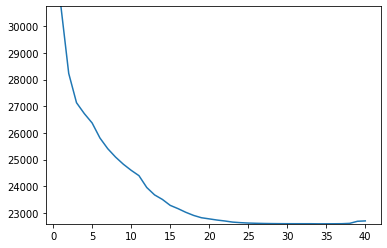

In [57]:
# create forward stepwise selection function to take a model, input/features (X)
# data, and output (y) data and perform feature selection based on minimum
# calculated test RMSE
def forward_step_sel(model, X, y):
  X2_train, X2_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
  features = []
  rmses = []
  for k in range(1, len(list(X.columns)) + 1):
    min_rmse = max(y)
    for column_name in X.columns:
      if column_name not in features:
        X_temp = X[features + [column_name]]
        model = model.fit(X_temp, y)
        y_test_pred = model.predict(X2_test[list(X_temp.columns)])
        test_rmse = sklearn.metrics.mean_squared_error(y_test, y_test_pred, squared = False)
        if test_rmse < min_rmse:
          min_rmse = test_rmse
          best_feature = column_name
    features.append(best_feature)
    rmses.append(min_rmse)
  best_rmse = min(rmses)
  best_features = features[: rmses.index(min(rmses)) + 1]
  # display minimum RMSE generated and the corresponding features
  print(f'The best RMSE is {best_rmse}, generated using the following {len(best_features)} features:\n{best_features}')
  # plot RMSE vs Number of Features
  sns.lineplot(x = range(1, len(list(X.columns)) + 1), y = rmses)
  plt.ylim(min(rmses), max(rmses))
  return best_rmse, best_features

enet_rmse, enet_features = forward_step_sel(ElasticNet(l1_ratio = 1, alpha = 74), X, y)

# Additional Considerations

##### Dr. Chaturvedi's suggestions from Week 1:

1. Please note the definition of “outliers” depends on context, type of model being built – supervised or unsupervised. Outlier to one model can be an inlier to another model.  
  
  
2. Missing Data – this is another important topic. It needs some judgement for sure. Again – context is the key. Sometimes it is appropriate to ignore missing values, sometimes it is okay to fill in. A lot of care must be administered. If the data are missing at random, then missing values can be imputed using predictive models. If not – then imputation is questionable.

##### Module 2 Assignment Instructions
[1. Conduct your analysis using a cross-validation design.](#q1)  
[2. Conduct EDA and provide appropriate visualizations in the process.](#q2)  
[3. Build a minimum of two separate regression models using the training set.](#q3)  
[4. Evaluate polynomial, indicator, dichotomous, & piecewise model components.](#q4)  
[5. Create at least one feature from the data set.](#q5)  
[6. Evaluate the models’ assumptions.](#q6)  
[7. Evaluate goodness of fit metrics on the training and validation sets.](#q7)  
[8. Submit predictions for the unseen test set available on Kaggle.com.](#q8)  
[9. Provide your Kaggle user name and a screen snapshot of your Kaggle scores.](#q9)  
[10. Discuss what your models tell you in layman’s terms](#q10)  

### Select (1) train.csv, (2) test.csv, and (3) data_descriptions.txt
##### Note: if running locally, you will be prompted 3 times (can't select multiple files)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import io

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from numpy import std
from numpy import mean
from numpy import absolute
from numpy import sqrt

uploaded = files.upload()
train_init = pd.read_csv(io.BytesIO(uploaded['train.csv']))
train = train_init.copy()
test = pd.read_csv(io.BytesIO(uploaded['test.csv']))
data_desc_file = uploaded['data_description.txt']

    
import warnings
warnings.filterwarnings('ignore')

from scipy import stats

sns.set_style('darkgrid')


In [ ]:
train = train_init.copy()

<a name="q1"></a>
### Q1
> 1. Conduct your analysis using a cross-validation design.

Below is a function that applies k-fold cross validation to a supplied set of training data & labels.  
We will use it below during the model selection portion models.

In [ ]:
from sklearn.model_selection import cross_val_score

def rmse_cross_val(model_name, current_model, X_array, y_series):
    
    # kfold_arg = KFold(n_splits=5, random_state=24, shuffle=True)
    
    rmse = sqrt(-cross_val_score(current_model, 
                                X = X_array, 
                                y = y_series, 
                                scoring="neg_mean_squared_error", 
                                cv = 5, 
                                error_score='raise',
                                n_jobs=-1,
                                 
                               )
               )
    
    print(f'Mean of Cross Validation RMSEs for {model_name} = {mean(rmse)}')
    print(f'StDev of Cross Validation RMSEs for {model_name} = {std(rmse)}')
    
    return (model_name, rmse, mean(rmse), std(rmse))

<a name="q2"></a>
## Q2
> Conduct EDA and provide appropriate visualizations in the process

We conducted a fairly thorough EDA during the Module 1 portion of this assignment, which we won't rehash here to avoid repitition.  However, we did further exploratory analysis of the dataset this week that produced some insights that were not included previously.  We've included these here:

**Log-transformation of target**  

Last week we noted that the target variable's marginal distribution exhibits right (positive) skew and is leptokurtic:

In [ ]:
print(f'Target\'s skewness: {round(train.SalePrice.skew(),3)}')
print(f'Target\'s kurtosis: {round(train.SalePrice.kurt(),3)}')

plt.figure(figsize=(12, 5))

plt.subplot(121)
sns.distplot(train.SalePrice)
plt.title('SalePrice histogram & KDE')

plt.subplot(122)
stats.probplot(train.SalePrice, plot=plt)
plt.title('QQ plot of SalePrice')
plt.show();

Applying a log-transform to the target (or, similarly, numpy's log+1 function) implies that the target appears to be lognormally distributed:

In [ ]:
log_target = np.log(train.SalePrice)

print(f'log_target\'s skewness: {round(log_target.skew(),3)}')
print(f'log_target\'s kurtosis: {round(log_target.kurt(),3)}')

plt.figure(figsize=(12, 5))

plt.subplot(121)
sns.distplot(log_target)
plt.title('SalePrice histogram & KDE of log(target)')

plt.subplot(122)
stats.probplot(log_target, plot=plt)
plt.title('QQ plot of log(target)')
plt.show();

In the model selection section below, we'll address further whether or not modelling with this transformation seems to generate more accuracy.

In [ ]:
# Separate features from target before moving forward
target = train['SalePrice'].reset_index(drop=True)
train = train.loc[:, train.columns != 'SalePrice']
print(train.shape)
print(test.shape)
all_features = pd.concat([train, test]).reset_index(drop=True)
print(all_features.shape)

In [ ]:
# Apply data transformations to both test and train predictors
# We'll fit to the training set only and then test vs the test set only
train = all_features

**Missing Values Deep Dive**  

Last week [we discussed](#catmissing) that the null values in the training set's categorical feature columns appear to be due to the given house not having the element (e.g. a pool) that the feature refers to (e.g. the pool quality feature).  In other words, it is not dirty data.  
  
We noted that, since many of the features are categorical, imputing appropriate values for these null values could provide informative value to the model.  
  
The below code leverages the structure of the provided *data_descriptions.txt* file to fill these categorical nulls appropriately.  We've provided a dataframe showing the replacement values for each feature:

In [ ]:
# Read in the raw data descriptions text file into a list
try:
    with open('data_description.txt') as f:
        lines = f.readlines()
except:
    with open(data_desc_file) as f:
        lines = f.readlines()

# Extract the feature descriptions into a dict
feature_desc_dict = {}
for line in lines:
    if not line.startswith(('\n', '\t', ' ')):
        cur_feature = line.split(': ')[0]
        cur_feature_desc = []
        feature_desc_dict[cur_feature] = line.split(': ')[1].replace('\n',  '').replace('\t',  '')

# Extract the categorical variable levels into a second dict
feature_options_dict = {}
for line_idx, line in enumerate(lines):
    if not line.startswith(('\n', '\t', ' ')):
        cur_feature = line.split(': ')[0]
        feature_options_dict[cur_feature] = []
    elif line.startswith(' ') and line.strip()!='':
        feature_options_dict[cur_feature].append(" ".join(line.strip().split()[1:]))

# Create a new df to display the contents of the created dicts for features with >0 nulls
missing_data_df = train.select_dtypes(include=['object']).isnull().sum().to_frame()
missing_data_df.columns = ['Num_Missing']
missing_data_df = missing_data_df.loc[missing_data_df.Num_Missing > 0, :].sort_values('Num_Missing', ascending=False)
missing_data_df['Feature_Desc'] = ''
missing_data_df['Feature_Desc'] = missing_data_df.index.map(feature_desc_dict)
missing_data_df['Feature_Cats'] = ''
missing_data_df['Feature_Cats'] = missing_data_df.index.map(feature_options_dict)

# For categorical variables with nulls, return the last category level option provided in the file as the filler value
def get_last_value(cat_list):
    if cat_list:
        
        # MasVnrType is the only feature not to fit the pattern...handled with if-statement
        if 'None' in cat_list:
            cat_list.append(cat_list.pop(cat_list.index('None')))
        return cat_list[-1]
    else:
        return np.nan

missing_data_df['Missing_Value_Filler'] = missing_data_df.apply(lambda x: get_last_value(x['Feature_Cats']), axis=1)

cat_null_filler_dict = dict(zip(missing_data_df.index, missing_data_df.Missing_Value_Filler.values))
train.fillna(value=cat_null_filler_dict, inplace=True)

pd.options.display.max_colwidth = 200
missing_data_df

We'll also apply [the treatment described last week](#numnull) to the numeric columns with missing values:

In [ ]:
train['GarageYrBlt'].fillna(train['YearBuilt'], inplace=True)
train.drop(['Id','LotFrontage'], axis=1, inplace=True)
train['MasVnrArea'].fillna(train['MasVnrArea'].mean(), inplace=True)

# A few numerics still missing
for i in train.columns[train.isnull().any(axis=0)]:
    train[i].fillna(train[i].median(),inplace=True)

#Check
print(f'{train.isnull().sum().max()} columns with null values remain')

**Predictor skewness correction**  

Last week we noticed severe skewness in a large number of the predictor variables as well:

In [ ]:
feature_skew_df = train.select_dtypes(include=[np.number]).skew().to_frame(name='skewness').reset_index(drop=False)
feature_skew_df.rename({'index':'feature'}, axis=1, inplace=True)
feature_skew_df.sort_values('skewness', ascending=False, inplace=True)
feature_skew_df.reset_index(drop=True, inplace=True)
feature_skew_df.head(20)

In [ ]:
skewed = feature_skew_df.loc[(feature_skew_df.skewness > .9) & (feature_skew_df.skewness < 4), 'feature'].tolist()
severely_skewed = feature_skew_df.loc[(feature_skew_df.skewness >= 4), 'feature'].tolist()

not_skewed = [feat for feat in feature_skew_df.feature.tolist() if (feat not in skewed) and (feat not in severely_skewed)]

from scipy.special import boxcox1p
lam = 0.15
for feat in severely_skewed:
    train[feat] = boxcox1p(train[feat], lam)
    
for feat in skewed:
    train[feat] = np.log1p(train[feat])
    
# Apply StandardScaler to the remaining features (since it's more robust to outliers than other scalers):
sc = preprocessing.StandardScaler()
train[not_skewed] = sc.fit_transform(train[not_skewed])

**Categorical Encoding**  

Seeing as we're performing regression, we'll need to work with numeric features.  Last week [we demonstrated](#likert) how categorical features could be encoded to numeric values.  We initially tried applying one-hot encoding to the nominal categorical variables and sklearn's OrdinalEncoder to the ordinal ones, but this caused issues (likely due to correlations between category levels), so we'll use OrdinalEncoder for all ordinal categorical variables (which, presumably, provide more information) and drop all the nominal categorical variables.  Doing this resulted in meaningful model performance increase vs. using only numeric columns.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder#, OneHotEncoder
# cat_nominal_feats = ['MSZoning','Heating','CentralAir','GarageType','Fence','MiscFeature','Condition2','Alley','Neighborhood','Condition1','Foundation','RoofStyle','Exterior1st','Exterior2nd','MasVnrType','SaleCondition']
cat_ordinal_feats = ['FireplaceQu','BsmtFinType1','BsmtFinType2','HeatingQC','Electrical','KitchenQual','Functional','BsmtCond','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','SaleType','BsmtExposure','BsmtQual','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope','BldgType','HouseStyle','RoofMatl','ExterQual','ExterCond']

ordnl = OrdinalEncoder()
train[cat_ordinal_feats] = ordnl.fit_transform(train[cat_ordinal_feats])

train = train.select_dtypes(include=[np.number])

<a name="q3"></a>
## Q3
> 3. Build a minimum of two separate regression models using the training set

Now that data transformations have been applied, we'll recreate the original training and test sets.  We'll fit only on the training data (row indices have been preserved).

In [ ]:
X = train.iloc[:len(target), :] # training data only (no target)
y = target # training data target
X_test = train.iloc[len(target):, :] # test data only (predictors only...not used to fit models)
X.shape, target.shape, X_test.shape

In [ ]:
# Collect metrics of each regression model for performance comparison
model_data = []

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
# from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet

# MODEL 1: lin_reg_rawtarget
# lin_reg_raw_model = LinearRegression()
# lin_reg_raw_cv_score = rmse_cross_val("lin_reg_raw", lin_reg_raw_model, X, y )
# model_data.append([lin_reg_raw_cv_score[i] for i in [0, 2, 3]])


# MODEL 2: lin_reg_logtarget
lin_reg_logtarget_model = Pipeline([  ('ttr', TransformedTargetRegressor(regressor=LinearRegression(), func = np.log1p, inverse_func = np.expm1))  ])
lin_reg_logtarget_cv_score = rmse_cross_val("lin_reg_logtarget", lin_reg_logtarget_model, X, y )
model_data.append([lin_reg_logtarget_cv_score[i] for i in [0, 2, 3]])


# MODEL 3: gboosted_rawtarget
gboosted_raw_model = GradientBoostingRegressor()
gboosted_raw_cv_score = rmse_cross_val("gboosted_raw", gboosted_raw_model, X, y)
model_data.append([gboosted_raw_cv_score[i] for i in [0, 2, 3]])


# MODEL 4: gboosted_logtarget
gboosted_logtarget_model = Pipeline([  ('ttr', TransformedTargetRegressor(regressor=GradientBoostingRegressor(), func = np.log1p, inverse_func = np.expm1))  ])
gboosted_logtarget_cv_score = rmse_cross_val("gboosted_logtarget", gboosted_logtarget_model, X, y)
model_data.append([gboosted_logtarget_cv_score[i] for i in [0, 2, 3]])

lasso_alphas = [1, 0.1, 0.001, 0.0005]

# MODEL 5: lasso_rawtarget
lasso_raw_model = make_pipeline(RobustScaler(), LassoCV(alphas=lasso_alphas))
lasso_raw_cv_score = rmse_cross_val("lasso_raw", lasso_raw_model, X, y)
model_data.append([lasso_raw_cv_score[i] for i in [0, 2, 3]])


# MODEL 6: lasso_logtarget
lasso_logtarget_model = Pipeline([  ('ttr', TransformedTargetRegressor(regressor=LassoCV(alphas=lasso_alphas), func = np.log1p, inverse_func = np.expm1))  ])
lasso_logtarget_cv_score = rmse_cross_val("lasso_logtarget", lasso_logtarget_model, X, y)
model_data.append([lasso_logtarget_cv_score[i] for i in [0, 2, 3]])


# MODEL 7: enet_rawtarget
enet_raw_model = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9))
enet_raw_cv_score = rmse_cross_val("enet_raw", enet_raw_model, X, y)
model_data.append([enet_raw_cv_score[i] for i in [0, 2, 3]])


# MODEL 8: enet_logtarget
enet_logtarget_model = Pipeline([    ('ttr', TransformedTargetRegressor(regressor=ElasticNet(alpha=0.0005, l1_ratio=.9), func = np.log1p, inverse_func = np.expm1))  ])
enet_logtarget_cv_score = rmse_cross_val("enet_logtarget", enet_logtarget_model, X, y)
model_data.append([enet_logtarget_cv_score[i] for i in [0, 2, 3]])

ridge_alphas = [1e-15, 1e-10, 1e-5, 0.1, 0.5, 1, 5, 10, 15, 20, 30, 50, 75, 100]

# MODEL 9: ridge_rawtarget
lasso_raw_model = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas))
lasso_raw_cv_score = rmse_cross_val("lasso_raw", lasso_raw_model, X, y)
model_data.append([lasso_raw_cv_score[i] for i in [0, 2, 3]])


# MODEL 10: ridge_logtarget
lasso_logtarget_model = Pipeline([  ('ttr', TransformedTargetRegressor(regressor=RidgeCV(alphas=ridge_alphas), func = np.log1p, inverse_func = np.expm1))  ])
lasso_logtarget_cv_score = rmse_cross_val("lasso_logtarget", lasso_logtarget_model, X, y)
model_data.append([lasso_logtarget_cv_score[i] for i in [0, 2, 3]])

Error on Training Set (using cross validation):

In [ ]:
model_df = pd.DataFrame(model_data, columns=['Model', 'Mean_CV_RMSE', 'Std_CV_RMSE'])
model_df['Mean_CV_RMSE'] = model_df['Mean_CV_RMSE'].round(2)
model_df['Std_CV_RMSE'] = model_df['Std_CV_RMSE'].round(2)
model_df = model_df.sort_values('Mean_CV_RMSE')
model_df.reset_index(drop=True, inplace=True)
model_df

Now we need to actually fit the models to the training set...

In [ ]:
# lin_reg_raw_model_fulldata_fitted = lin_reg_raw_model.fit(X, target)
lin_reg_logtarget_model_fulldata_fitted = lin_reg_logtarget_model.fit(X, target)
gboosted_raw_model_fulldata_fitted = gboosted_raw_model.fit(X, target)
gboosted_logtarget_model_fulldata_fitted = gboosted_logtarget_model.fit(X, target)
lasso_raw_model_fulldata_fitted = lasso_raw_model.fit(X, target)
lasso_logtarget_model_fulldata_fitted = lasso_logtarget_model.fit(X, target)
enet_raw_model_fulldata_fitted = enet_raw_model.fit(X, target)
enet_logtarget_model_fulldata_fitted = enet_logtarget_model.fit(X, target)
lasso_raw_model_fulldata_fitted = lasso_raw_model.fit(X, target)
lasso_logtarget_model_fulldata_fitted = lasso_logtarget_model.fit(X, target)

Here's a simple combination of all the models:

In [ ]:
from sklearn.metrics import mean_squared_error
def rmse_func(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def blended_predictions(X_train):
    return ( #(.1 * lin_reg_raw_model_fulldata_fitted.predict(X)) + \
    (.1 * lin_reg_logtarget_model_fulldata_fitted.predict(X)) + \
    (.1 * gboosted_raw_model_fulldata_fitted.predict(X)) + \
    (.1 * gboosted_logtarget_model_fulldata_fitted.predict(X)) + \
    (.1 * lasso_raw_model_fulldata_fitted.predict(X)) + \
    (.1 * lasso_logtarget_model_fulldata_fitted.predict(X)) + \
    (.1 * enet_raw_model_fulldata_fitted.predict(X)) + \
    (.1 * enet_logtarget_model_fulldata_fitted.predict(X)) + \
    (.1 * lasso_raw_model_fulldata_fitted.predict(X)) + \
    (.1 * lasso_logtarget_model_fulldata_fitted.predict(X)) )

blended_score = rmse_func(target, blended_predictions(X))
print(blended_score)

In [ ]:
model_df.loc[len(model_df)] = ['Blend', round(blended_score, 2), np.nan]
model_df = model_df.sort_values('Mean_CV_RMSE')
model_df.reset_index(drop=True, inplace=True)
model_df

In [ ]:
plt.figure(figsize = (18,12))
model_df.set_index('Model')['Mean_CV_RMSE'].plot()
plt.title('Model Comparison')
plt.show();

<a name="q4"></a>
## Q4
> 4. Evaluate polynomial, indicator, dichotomous, & piecewise model components

In [ ]:
# polynomial regression with raw data
from sklearn.preprocessing import PolynomialFeatures
poly_reg_raw_model = make_pipeline(StandardScaler(), PolynomialFeatures(degree = 3), LinearRegression())
poly_reg_raw_model.fit(X, target)
poly_reg_raw_cv_score = rmse_cross_val("poly_reg_raw", poly_reg_raw_model, X, target)

# polynomial regression with log transformed data
poly_reg_logtarget_model = Pipeline([('ttr', TransformedTargetRegressor(regressor = poly_reg_raw_model,
                                                                        func = np.log1p,
                                                                        inverse_func = np.expm1))])
poly_reg_logtarget_model.fit(X, target)
poly_reg_logtarget_cv_score = rmse_cross_val("poly_reg_logtarget", poly_reg_logtarget_model, X, target)

In [ ]:
# piecewise linear regression with raw data
from mlinsights.mlmodel import PiecewiseRegressor
from sklearn.tree import DecisionTreeRegressor
piecewise_raw_model = PiecewiseRegressor(binner = DecisionTreeRegressor())
piecewise_raw_model.fit(X, target)
piecewise_raw_cv_score = rmse_cross_val("piecewise_raw", piecewise_raw_model, X, target)

# piecewise linear regression with log data
piecewise_logtarget_model = Pipeline([('ttr', TransformedTargetRegressor(regressor = piecewise_raw_model,
                                                                        func = np.log1p,
                                                                        inverse_func = np.expm1))])
piecewise_logtarget_model.fit(X, target)
piecewise_logtarget_cv_score = rmse_cross_val("piecewise_logtarget", piecewise_logtarget_model, X, target)